In [1]:
import numpy as np
import scipy
import astropy
import matplotlib.pyplot as plt
import datetime
from dateutil import parser
import pandas as pd

In [2]:
data = np.load('/Users/ketansand/Downloads/exposure_29.503_65.717_res_4s_src_R3.npz', allow_pickle=True)
exp_u = data['exp_mins_u']
print(len(exp_u))
# exp_blocks = []
# i = 0
# d = 16
# while i < len(exp_u):
#     if (i+d) < len(exp_u):
#         j = i + d
#     else:
#         j = len(exp_u) - i
#     exp_blocks.append(np.sum(exp_u[i:j]))
#     i = i+d
        

# exp_blocks = np.array(exp_blocks)
# print(exp_blocks/60)
# exp_cum = np.cumsum(exp_blocks)
# print(exp_cum/60)

1221


In [3]:
burst = np.load('/Users/ketansand/Downloads/R3_after_excision.npz', allow_pickle=True)

dat = burst["Dates"]
event = burst["Events"]
dat = np.unique(dat)
burst_date = []
burst_date = dat



# for da in dat:
#     ds = parser.parse(da)
#     np.array(burst_date.append(ds))

limit = datetime.datetime(2021, 12, 31, 11, 59, 59)
w = []
for i in range(len(burst_date)-1):
#     if burst_date[i] < limit:
    a = burst_date[i]
    b = burst_date[i+1]
        #print(a, b)
    w.append((b-a).total_seconds())
w = np.array(w)

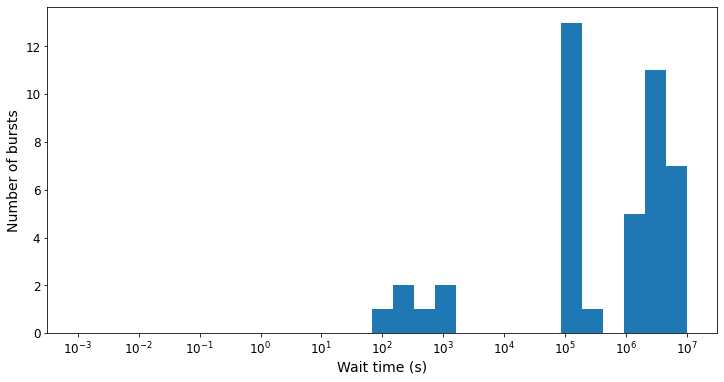

In [4]:
plt.figure(figsize=(12,6))
logbin = np.logspace(-3,7,30)
plt.xscale('log')
plt.xticks(np.logspace(-3,7,11),fontsize=12)
plt.yticks(fontsize=12)
plt.hist(w,bins=logbin)
plt.xlabel("Wait time (s)", fontsize = 14)
plt.ylabel("Number of bursts", fontsize = 14)
plt.savefig("wait_time.jpeg", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
from astropy.time import Time
t = Time(burst_date, format='datetime', scale='utc')

In [6]:
plt.figure(figsize=(18,6))
t_date = Time(date_list, format='datetime', scale='utc')
active_mjd = 58369.40
period = 16.33
while active_mjd < t_date[-1].mjd:
    plt.axvline(active_mjd, alpha=0.2, c='k')
    active_mjd = active_mjd + period
plt.scatter(t_date.mjd,exp_u)
plt.show()

NameError: name 'date_list' is not defined

<Figure size 1296x432 with 0 Axes>

In [35]:
ref_mjd = 58369.40
phase = (t_date.mjd-ref_mjd)/period
phase_burst = (t.mjd-ref_mjd)/period

max_cycle = int(np.max(phase))
burst_count = []
for i in range(0,max_cycle):
    count = 0
    for j in range(len(phase_burst)):
        if i < phase_burst[j] < i+1:
            #print(phase_burst[j],i)
            count = count + 1
    i = i + 1
    burst_count.append(count)
#     for j in range(len(phase):
#         if int(phase[j]) < phase_burst[i] < int(phase[j+1]):
#             print(phase_burst[i], phase[j], phase[j+1])

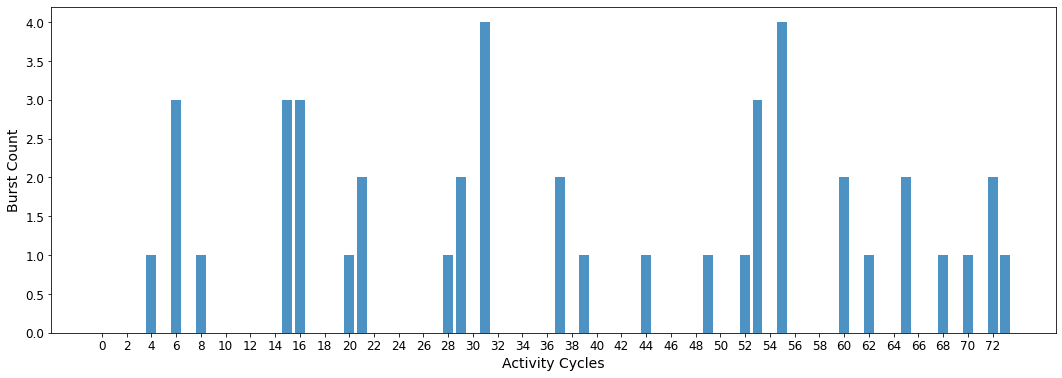

In [36]:
plt.figure(figsize=(18,6))
x = np.arange(0,len(burst_count),1)
plt.bar(x,burst_count, alpha = 0.8, linewidth = 1)

plt.xlabel("Activity Cycles", fontsize = 14)
plt.ylabel("Burst Count", fontsize = 14)
plt.xticks(np.arange(min(x), max(x)+1, 2.0), fontsize = 12)
plt.yticks(fontsize=12)
plt.savefig("Countvscycle_excised.jpeg", bbox_inches ='tight', dpi=300)

In [37]:
#### Rate error ####

from scipy.stats import chi2
def get_poisson_error(r, conf_level=0.68):
    low_lim = 0.5 * chi2.ppf((1 - conf_level) / 2, 2 * r)
    low_lim[np.isnan(low_lim)] = 0 
    upp_lim = 0.5 * chi2.ppf((1 + conf_level) / 2, 2 * (r+1))
    upp_lim[np.isnan(upp_lim)] = 0
    return low_lim, upp_lim


[0 0 0 0 1 0 3 0 1 0 0 0 0 0 0 3 3 0 0 0 1 2 0 0 0 0 0 0 1 2 0 4 0 0 0 0 0
 2 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 3 0 4 0 0 0 0 2 0 1 0 0 2 0 0 1 0 1 0 2 1]
0.0 5.949805571151509 0 0.62
0.21221816126857684 2.16
0.21 1.71 0.18


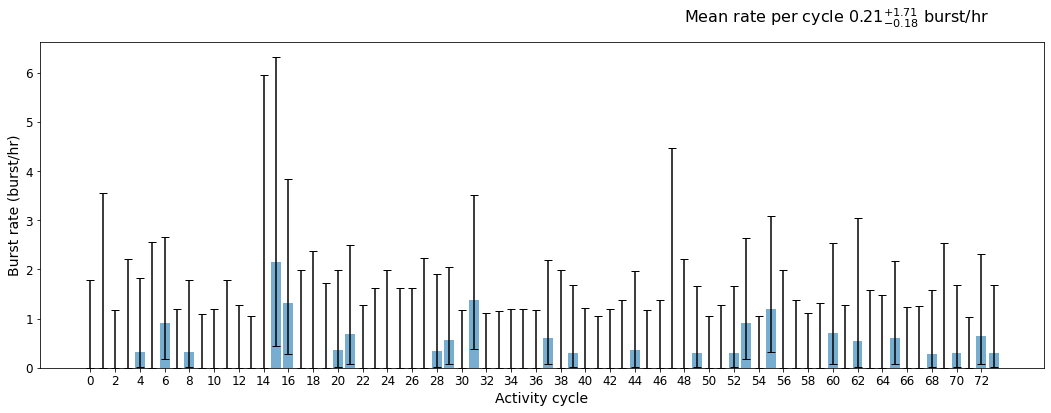

In [44]:
exp = np.zeros(max_cycle)
for j in range(max_cycle):
    e = 0
    for i in range(len(phase)):
        if j < phase[i] < j+1:
            e = e + exp_u[i]
    exp[j] = e
plt.figure(figsize=(18,6))
print(burst_count)
burst_count = np.array(burst_count)
exp = exp/60
rate = np.divide(burst_count,exp)

get_poisson_error(rate, conf_level=0.95) # returns 1-sigma lower and upper limit on the rate
low_err = rate - (get_poisson_error(burst_count, conf_level=0.95)[0])/exp
upp_err = (get_poisson_error(burst_count, conf_level=0.95)[1])/exp - rate

print(low_err[14], upp_err[14], burst_count[14], exp[14])

asymmetric_error = np.array(list(zip(low_err, upp_err))).T

print(np.mean(rate), np.max(rate))
x = np.arange(0,len(burst_count),1)
plt.bar(x,rate, yerr=asymmetric_error, capsize=4, alpha = 0.6, linewidth = 0.2)

plt.xticks(np.arange(min(x), max(x)+1, 2.0), fontsize = 12)
plt.yticks(fontsize=12)
mean_rate = round(np.mean(rate),2)
mean_upper = round(np.mean(upp_err),2)
mean_lower = round(np.mean(low_err),2)
plt.text(x = 48, y=7 , s=r"Mean rate per cycle ${0.21}^{+1.71}_{-0.18}$ burst/hr", fontsize= 16)
print(mean_rate, mean_upper, mean_lower)
#plt.yticks(np.arange(min(rate), max(rate)+0.25, 0.25), fontsize = 12)
plt.xlabel("Activity cycle", fontsize = 14)
plt.ylabel("Burst rate (burst/hr)", fontsize = 14)
plt.savefig("ratevscycle_err_excised.jpeg", bbox_inches ='tight', dpi=300)
plt.show()

0.5945945945945946
[ 3.68887945  3.68887945  3.68887945  3.68887945  5.57164339  3.68887945
  8.76727307  3.68887945  5.57164339  3.68887945  3.68887945  3.68887945
  3.68887945  3.68887945  3.68887945  8.76727307  8.76727307  3.68887945
  3.68887945  3.68887945  5.57164339  7.22468767  3.68887945  3.68887945
  3.68887945  3.68887945  3.68887945  3.68887945  5.57164339  7.22468767
  3.68887945 10.24158868  3.68887945  3.68887945  3.68887945  3.68887945
  3.68887945  7.22468767  3.68887945  5.57164339  3.68887945  3.68887945
  3.68887945  3.68887945  5.57164339  3.68887945  3.68887945  3.68887945
  3.68887945  5.57164339  3.68887945  3.68887945  5.57164339  8.76727307
  3.68887945 10.24158868  3.68887945  3.68887945  3.68887945  3.68887945
  7.22468767  3.68887945  5.57164339  3.68887945  3.68887945  7.22468767
  3.68887945  3.68887945  5.57164339  3.68887945  5.57164339  3.68887945
  7.22468767  5.57164339]
Y_low [9.17390069e-01 7.90996856e-02 3.41008720e-03 9.80087730e-05
 2.11264090e

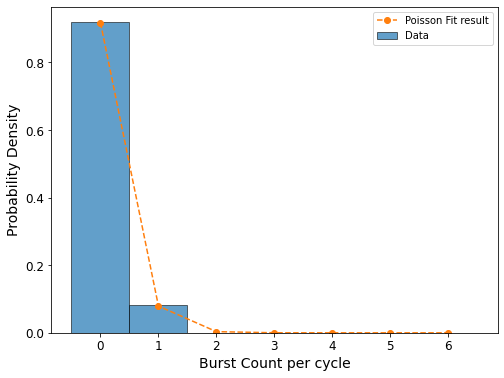

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Y High [0.00904217 0.04255114 0.10011977 0.15704976 0.18476341 0.17389402
 0.13638672 0.09168805 0.05393385 0.02820055 0.01327077 0.00567731
 0.00222638 0.00080593]


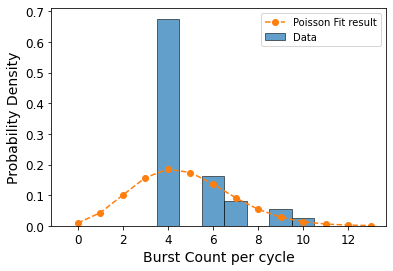

[0. 1. 2. 3. 4. 5. 6.]
[0.3372566] [[0.00267174]]


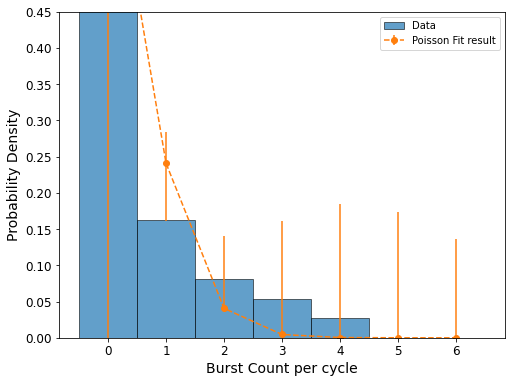

In [45]:
# nc = np.arange(0,8,1) - 0.5
# plt.hist(burst_count, bins=nc)
# plt.show()
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

plt.figure(figsize=(8,6))

nc = np.arange(0,8,1) - 0.5
nc_high = np.arange(0,14,1) - 0.5
# plt.hist(burst_count, bins=nc)
# plt.show()

# get poisson deviated random numbers
data = burst_count
print(np.mean(data))

low_err = (get_poisson_error(data, conf_level=0.95)[0])#data - (get_poisson_error(data, conf_level=0.95)[0])
upp_err = (get_poisson_error(data, conf_level=0.95)[1]) #- data

print(upp_err)

entries_low, bin_edges_low, patches_low = plt.hist(low_err, bins=nc, density=True, label='Data', stacked = True, linewidth = 0.8,
                                      edgecolor = 'k', alpha=0.7)
bin_middles_low = 0.5 * (bin_edges_low[1:] + bin_edges_low[:-1])

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)


# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_middles_low, entries_low)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, 7)

y_low = fit_function(x_plot, *parameters)
print("Y_low", y_low)

plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    marker='o', linestyle='--',
    label='Poisson Fit result',
)
plt.xlabel("Burst Count per cycle", fontsize = 14)
plt.ylabel("Probability Density", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()


plt.show()

entries_high, bin_edges_high, patches_high = plt.hist(upp_err, bins=nc_high, density=True, label='Data', stacked = True, linewidth = 0.8,
                                      edgecolor = 'k', alpha=0.7)
bin_middles_high = 0.5 * (bin_edges_high[1:] + bin_edges_high[:-1])
print(bin_middles_high)

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)


# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_middles_high, entries_high)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, 14)
y_high = fit_function(x_plot, *parameters)
print("Y High", y_high)

plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    marker='o', linestyle='--',
    label='Poisson Fit result',
)
plt.xlabel("Burst Count per cycle", fontsize = 14)
plt.ylabel("Probability Density", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()

plt.show()

asymmetric_error = np.array(list(zip(low_err, upp_err))).T

plt.figure(figsize=(8,6))

# entries, bin_edges = np.histogram(data,nc)
# x = np.arange(0, len(entries),1)

# plt.bar(x, entries, yerr = asymmetric_error)
# plt.show()

# the bins should be of integer width, because poisson is an integer distribution
#bins = np.arange(11) - 0.5
entries, bin_edges, patches = plt.hist(data, bins=nc, density=True, label='Data', stacked = True, linewidth = 0.8,
                                      edgecolor = 'k', alpha=0.7)


# calculate bin centres
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
print(bin_middles)

y_asy_err = np.array(list(zip(y_low, y_high))).T

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)


# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries)
print(parameters, cov_matrix)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, 7)

plt.errorbar(
    x_plot,
    fit_function(x_plot, *parameters),
    yerr = y_asy_err,
    marker='o', linestyle='--',
    label='Poisson Fit result',
)
plt.xlabel("Burst Count per cycle", fontsize = 14)
plt.ylabel("Probability Density", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0,0.45)
plt.legend()
plt.savefig("Counthist_err_excised.jpeg", bbox_inches ='tight', dpi=300)
plt.show()

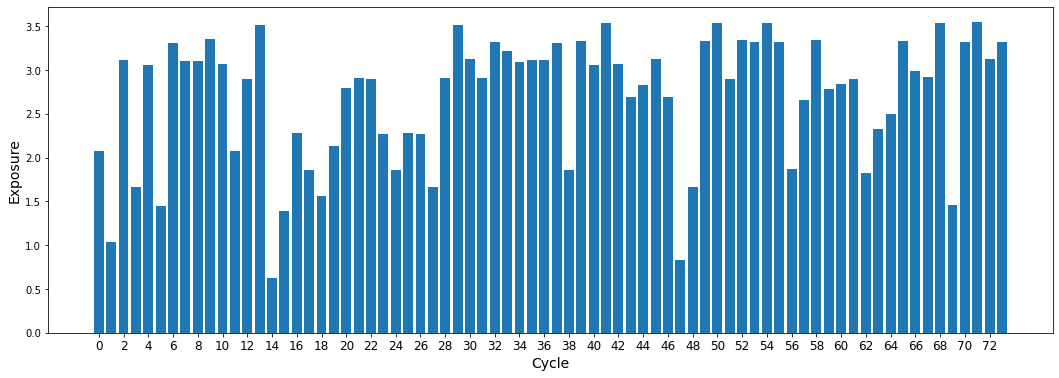

In [40]:
plt.figure(figsize=(18,6))
x = np.arange(0,len(burst_count),1)
plt.xticks(np.arange(min(x), max(x)+1, 2.0), fontsize = 12)
plt.xlabel("Cycle", fontsize = 14)
plt.ylabel("Exposure", fontsize = 14)
plt.bar(x,exp)
plt.savefig("expvscycle_excised.jpeg", bbox_inches ='tight', dpi=300)

44
(40,) [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


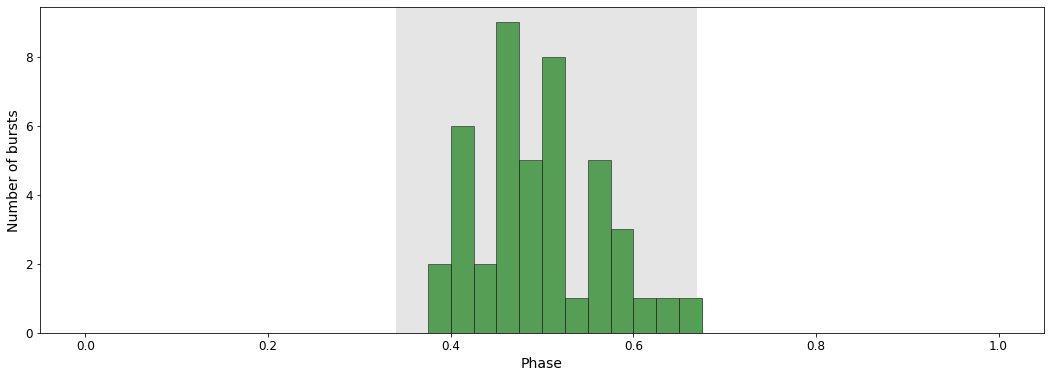

In [53]:
plt.figure(figsize=(18,6))
n=np.linspace(0,1,41)
phase_dec = []
for i in range(len(phase_burst)):
    if phase_burst[i] < phase[-1]:
        p_dec = phase_burst[i] % 1
        phase_dec.append(p_dec)
phase_decimal = np.array(phase_dec)
print(len(phase_decimal))
hist = plt.hist(phase_decimal, bins=n, stacked=True, density=False, edgecolor='black',color = 'g', linewidth = 0.8,
               alpha = 0.7)
print(hist[0].shape, n)
plt.axvspan(0.34,0.67, facecolor = 'gray', alpha = 0.2)
plt.xlabel("Phase", fontsize = 14)
plt.ylabel("Number of bursts", fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Burst_vs_phase_excised.jpeg", bbox_inches ='tight', dpi=300)
plt.show()

0.02564102564102564


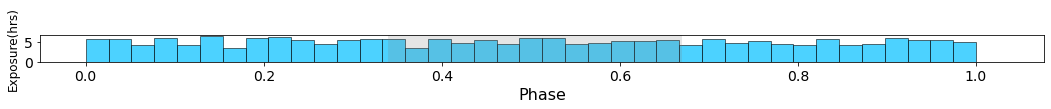

(40,)


In [54]:
plt.figure(figsize=(18,0.5))
n=np.linspace(0,1,40)
bin_width = n[1]-n[0]
print(bin_width)
exp_bin = np.zeros(len(n))
for j in range(len(exp_bin)):
    e = 0
    for i in range(len(phase)):
        phase_dec = phase[i]%1
        if n[j] < phase_dec < n[j+1]:
            e = e + exp_u[i]
    exp_bin[j] = e
plt.bar(n,exp_bin/60,bin_width, align='edge', alpha=0.7, edgecolor='black', color='deepskyblue', linewidth=0.8)
plt.axvspan(0.34,0.67, facecolor = 'gray', alpha = 0.2)
plt.xlabel("Phase", fontsize = 16)
plt.ylabel("Exposure(hrs)", fontsize = 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("Exposure_vs_phase_excised.jpeg", bbox_inches ='tight', dpi=300)
plt.show()
print(exp_bin.shape)
# for j in range(max_cycle):
#     e = 0
#     for i in range(len(phase)):
#         if j < phase[i] < j+1:
#             e = e + exp_u[i]
#     exp[j] = e
# print(exp)

(40,)
[0.46153846 0.48717949 0.51282051 0.53846154]
1.0970956116175534
[0.35897436 0.38461538 0.41025641 0.43589744] [0.56410256 0.58974359 0.61538462 0.64102564]
0.47699809200763194
0.4878048780487805
Mid 1.0935264696531903
Left 0.4897326353217024
Right 0.5024493732828209


Mid_lower 0.6541645020055468
Left_lower 0.35397626443831365
Right_lower 0.38487903399947015


Mid_upper 1.30245896427239
Left_upper 1.090310552985605
Right_upper 1.0618804559458919


<ipython-input-57-eb44ae73bbef>:5: RuntimeWarning: invalid value encountered in true_divide
  rate_bin = hist[0]/exp_bin_60
<ipython-input-57-eb44ae73bbef>:37: RuntimeWarning: invalid value encountered in true_divide
  low_err_bin = rate_bin - (get_poisson_error(hist[0], conf_level=0.95)[0])/exp_bin_60
<ipython-input-57-eb44ae73bbef>:38: RuntimeWarning: divide by zero encountered in true_divide
  upp_err_bin = (get_poisson_error(hist[0], conf_level=0.95)[1])/exp_bin_60 - rate_bin


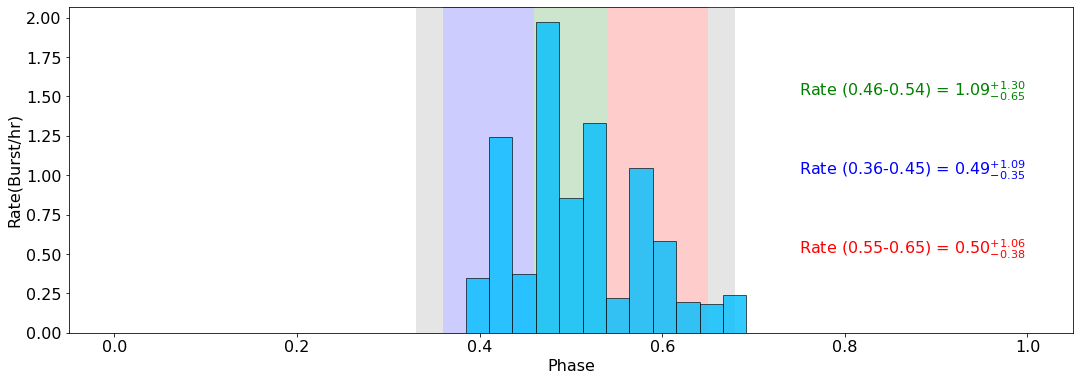

In [57]:
plt.figure(figsize=(18,6))

exp_bin_60 = exp_bin/60
print(exp_bin_60.shape)
rate_bin = hist[0]/exp_bin_60

print(n[18:22])
mid_b = np.sum(hist[0][18:22])
mid_e = np.sum(exp_bin_60[18:22])
mid_r = mid_b/mid_e
# mid_low_err = mid_r - (get_poisson_error(mid_b, conf_level=0.95)[0])/mid_e
# mid_upp_err = (get_poisson_error(mid_b, conf_level=0.95)[1])/mid_e - mid_r

print(mid_r)#, mid_low_err, mid_upp_err)

print(n[14:18], n[22:26])
left_b = np.sum(hist[0][14:18])
left_e = np.sum(exp_bin_60[18:22])
left_r = left_b/left_e
# left_low_err = left_r - (get_poisson_error(left_b, conf_level=0.95)[0])/left_e
# left_upp_err = (get_poisson_error(left_b, conf_level=0.95)[1])/left_e - left_r

print(left_r)#, left_low_err, left_upp_err)

right_b = np.sum(hist[0][22:26])
right_e = np.sum(exp_bin_60[22:26])
right_r = right_b/right_e
# right_low_err = right_r - (get_poisson_error(right_b, conf_level=0.95)[0])/right_e
# right_upp_err = (get_poisson_error(right_b, conf_level=0.95)[1])/right_e - right_r

print(right_r)#, right_low_err, right_upp_err)

print("Mid", np.mean(rate_bin[18:22]))
print("Left", np.mean(rate_bin[14:18]))
print("Right", np.mean(rate_bin[22:26]))
print("\n")       
low_err_bin = rate_bin - (get_poisson_error(hist[0], conf_level=0.95)[0])/exp_bin_60
upp_err_bin = (get_poisson_error(hist[0], conf_level=0.95)[1])/exp_bin_60 - rate_bin

print("Mid_lower", np.mean(low_err_bin[18:22]))
print("Left_lower", np.mean(low_err_bin[14:18]))
print("Right_lower", np.mean(low_err_bin[22:26]))
print("\n")
print("Mid_upper", np.mean(upp_err_bin[18:22]))
print("Left_upper", np.mean(upp_err_bin[14:18]))
print("Right_upper", np.mean(upp_err_bin[22:26]))


as_error = np.array(list(zip(low_err_bin, upp_err_bin))).T


plt.bar(n,rate_bin,bin_width ,align='edge', alpha=0.8, edgecolor='black', color='deepskyblue', linewidth=0.8, zorder=20)
# plt.text(x=0.75, y = 3, s=r"Rate (0.46-0.54) = $2.33^{+1.72}_{-1.10}$", fontsize=16, color = 'g')
# plt.text(x=0.75, y = 2.5, s=r"Rate (0.36-0.45) = $0.88^{+1.24}_{-0.52}$", fontsize=16, color = 'b')
# plt.text(x=0.75, y = 2, s=r"Rate (0.55-0.65) = $1.14^{+1.34}_{-0.69}$", fontsize=16, color = 'r')
plt.text(x=0.75, y = 1.5, s=r"Rate (0.46-0.54) = $1.09^{+1.30}_{-0.65}$", fontsize=16, color = 'g')
plt.text(x=0.75, y = 1, s=r"Rate (0.36-0.45) = $0.49^{+1.09}_{-0.35}$", fontsize=16, color = 'b')
plt.text(x=0.75, y = 0.5, s=r"Rate (0.55-0.65) = $0.50^{+1.06}_{-0.38}$", fontsize=16, color = 'r')
#plt.axvspan(0.34,0.67, facecolor = 'gray', alpha = 0.2)
plt.axvspan(0.46,0.54, facecolor = 'g', alpha = 0.2, zorder = 10)
plt.axvspan(0.36,0.46, facecolor = 'b', alpha = 0.2, zorder = 11)
plt.axvspan(0.54,0.65, facecolor = 'r', alpha = 0.2, zorder = 12)
plt.axvspan(0.33,0.36, facecolor = 'gray', alpha = 0.2, zorder = 9)
plt.axvspan(0.65,0.68, facecolor = 'gray', alpha = 0.2, zorder = 8)
plt.xlabel("Phase", fontsize = 16)
plt.ylabel("Rate(Burst/hr)", fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("Burstrate_vs_phase_multi_excised.jpeg", bbox_inches ='tight', dpi=300)
plt.show()

92


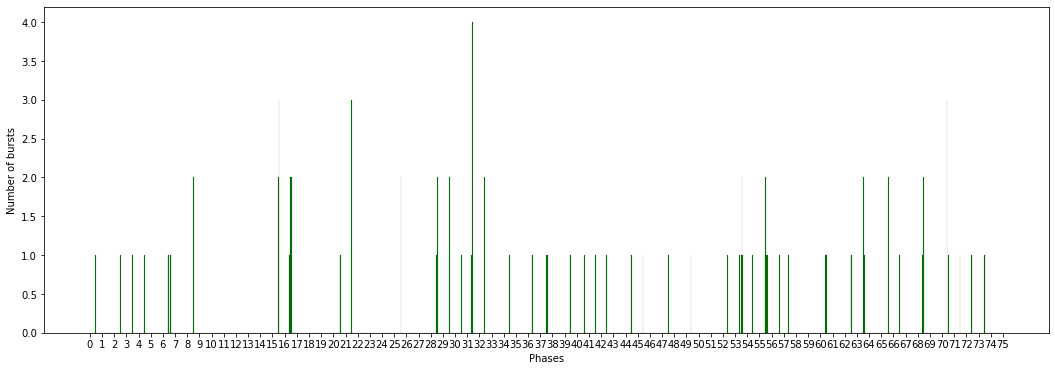

1199


In [150]:
plt.figure(figsize=(18,6))
n=np.linspace(0,int(max(phase))+1,1200)
phase_dec = []
for i in range(len(phase_burst)):
    if phase_burst[i] < phase[-1]:
        p_dec = phase_burst[i]
        phase_dec.append(p_dec)
phase_decimal = np.array(phase_dec)
print(len(phase_decimal))
histo = plt.hist(phase_decimal, bins=n, stacked=True, density=False, edgecolor='black',color = 'g', linewidth = 0.1)
#plt.axvspan(0.34,0.67, facecolor = 'gray', alpha = 0.2)
plt.xlabel("Phases")
plt.xticks(np.arange(min(n), max(n)+1, 1.0))
plt.ylabel("Number of bursts")
plt.show()
print(len(histo[0]))

0.06255212677231026


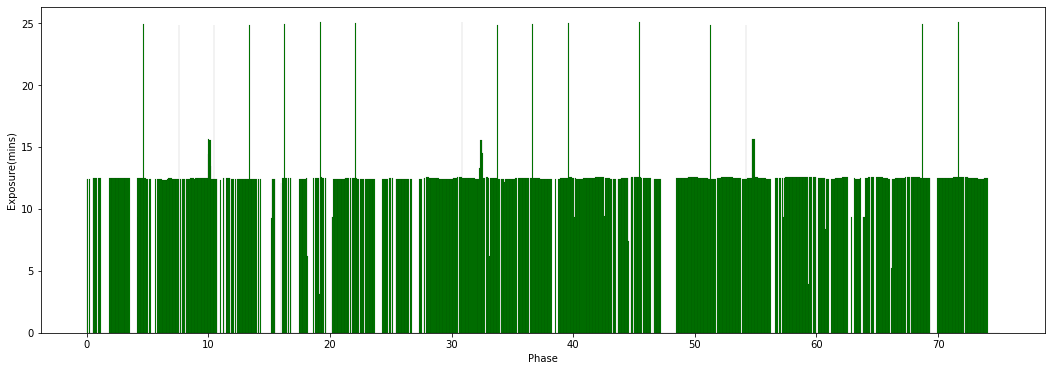

In [64]:
plt.figure(figsize=(18,6))
bin_width = n[1]-n[0]
print(bin_width)
exp_bin = np.zeros(len(n))
for j in range(len(exp_bin)):
    e = 0
    for i in range(len(phase)):
        phase_dec = phase[i]
        if n[j] < phase_dec < n[j+1]:
            e = e + exp_u[i]
    exp_bin[j] = e
plt.bar(n,exp_bin,bin_width, align='edge', alpha=1, edgecolor='black', color='g', linewidth=0.1)
#plt.axvspan(0.34,0.67, facecolor = 'gray', alpha = 0.2)
plt.xlabel("Phase")
plt.ylabel("Exposure(mins)")
plt.show()

<ipython-input-66-c2a769aa0223>:2: RuntimeWarning: divide by zero encountered in true_divide
  rate_bin = histo[0]/exp_bin_60[0:-1]
<ipython-input-66-c2a769aa0223>:2: RuntimeWarning: invalid value encountered in true_divide
  rate_bin = histo[0]/exp_bin_60[0:-1]


<BarContainer object of 1199 artists>

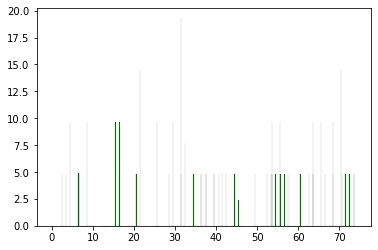

In [66]:
exp_bin_60 = exp_bin/60
rate_bin = histo[0]/exp_bin_60[0:-1]
plt.bar(n[0:-1],rate_bin,bin_width, align='edge', alpha=1, edgecolor='black', color='g', linewidth=0.1)

In [91]:
wait_time = []
for i in range(0,1):
    #if t[i] < t_date[-1]:
    a = t[i]
    b = t[i+1]
    print((b-a).total_seconds())
    
        

wait_time = np.array(wait_time)
print(np.max(wait_time), np.min(wait_time))

AttributeError: 'TimeDelta' object has no attribute 'total_seconds'

TypeError: '<' not supported between instances of 'TimeDelta' and 'float'

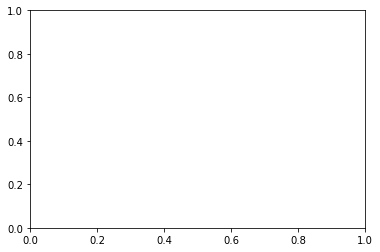

In [73]:
# hist, bins, _ = plt.hist(np.array, bins=8)

# # histogram on log scale. 
# # Use non-equal bin sizes, such that they look equal on log scale.
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# plt.subplot(212)
logbins = np.logspace(-4,8,20)
plt.hist(wait_time, bins=logbins)
plt.xscale('log')
plt.show()

In [67]:
from scipy.stats import poisson as p
x = p.pmf(6, 1.27)
print(x)

0.0016365747158445694


In [ ]:
data = {"exposure":exp_u, "date":date_list}
df = pd.DataFrame(data)

In [ ]:
### Random date generation ###
import random
from datetime import datetime, timedelta

min_year=2018
max_year=2020  #datetime.now().year

start = datetime(min_year, 8, 28, 0, 0, 0)
print(start)
years = max_year - min_year+1
end = start + timedelta(days=365 * years)
print(end)

burst = []

for i in range(10):
    random_date = start + (end - start) * random.random()
    print(random_date)
    burst.append(random_date)

In [94]:
import datetime as dt

a = dt.datetime(2013,12,30,23,59,59)
b = dt.datetime(2014,12,31,23,59,59)

(b-a).total_seconds()

31622400.0

In [10]:
base = parser.parse("Aug 28 2018 12:00AM")
date_list = [base + datetime.timedelta(days=x) for x in range(len(exp_u))]


In [13]:
burst_block = []
j = 0
while j < len(date_list): ### Search the date range in d days time ###
    if (j+d) < len(date_list):
        k = j + d
    else:
        k = len(date_list) - j
    count = 0
    for i in range(len(burst_date)):
        if date_list[j] <= burst_date[i] <= date_list[k]: ##search if there is a burst within those date##
            count = count+1
    burst_block.append(count)
    j = j+d
    


In [16]:
burst_block = np.array(burst_block)
exp_blocks_hr = exp_blocks/60
rate = np.divide(burst_block,exp_blocks_hr)
rate[np.isnan(rate)] = 0

<ipython-input-16-b9719ce9cc98>:3: RuntimeWarning: divide by zero encountered in true_divide
  rate = np.divide(burst_block,exp_blocks_hr)
<ipython-input-16-b9719ce9cc98>:3: RuntimeWarning: invalid value encountered in true_divide
  rate = np.divide(burst_block,exp_blocks_hr)


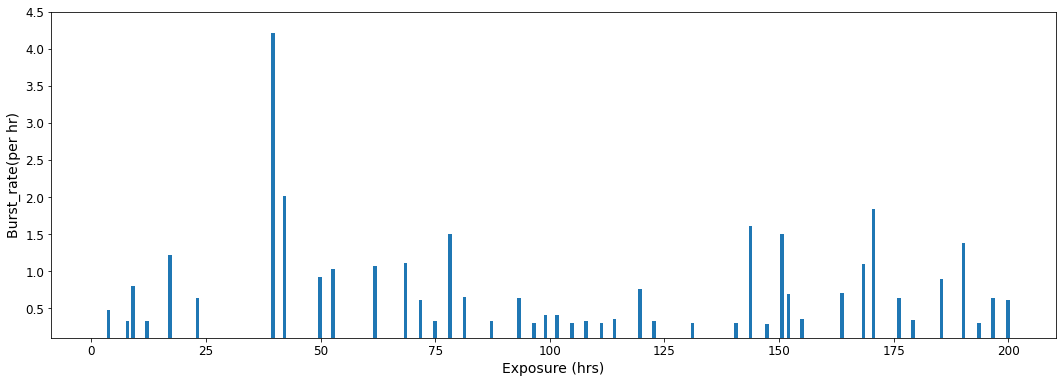

In [17]:
plt.figure(figsize=(18,6))
#plt.plot(exp_cum/60,rate,'o', markersize=4)
plt.bar(exp_cum/60,rate)
plt.ylim(0.1,4.5)
# for i in range(len(exp_cum)):
#     plt.axvline(exp_cum[i]/60, alpha = 0.2)
plt.xlabel('Exposure (hrs)', fontsize=14)

plt.ylabel('Burst_rate(per hr)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("rate_vs_exp.jpeg", bbox_inches ='tight', dpi=300)
#plt.show()